# DCGAN - Deep Convolutional GanS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


'2.10.0'

## Montando o dataset

In [2]:
(x_treinamento, y_treinamento),(_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
x_treinamento.shape,y_treinamento.shape

((60000, 28, 28), (60000,))

3


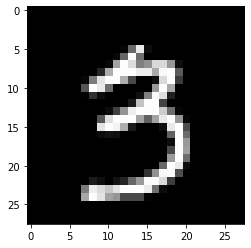

In [9]:
i = np.random.randint(0,60000)
print(y_treinamento[i])
plt.imshow(x_treinamento[i],cmap='gray');

In [12]:
x_treinamento = x_treinamento.reshape(x_treinamento.shape[0],28,28,1).astype('float32')
x_treinamento.shape

(60000, 28, 28, 1)

In [14]:
x_treinamento[0].min(),x_treinamento[0].max() #255 -> escuro 0 -> claro

(0.0, 255.0)

In [15]:
#gans recomendavel valores entre -1 e 1
x_treinamento = (x_treinamento - 127.5) / 127.5
x_treinamento[0].min(),x_treinamento[0].max() #255 -> escuro 0 -> claro

(-1.0, 1.0)

In [16]:
buffer_size = x_treinamento.shape[0]
batch_size = 256

In [17]:
type(x_treinamento)

numpy.ndarray

In [18]:
x_treinamento = tf.data.Dataset.from_tensor_slices(x_treinamento).shuffle(buffer_size).batch(batch_size)

In [19]:
type(x_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [20]:
x_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Construção do Gerador 

In [23]:
def cria_gerador():
    network = tf.keras.Sequential()
    
    network.add(layers.Dense(units = 7*7*256, use_bias = False,input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    network.add(layers.Reshape((7,7,256)))
    
    network.add(layers.Conv2DTranspose(filters=128,kernel_size=(5,5),padding='same',use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    network.add(layers.Conv2DTranspose(filters=64,kernel_size=(5,5),padding='same',use_bias=False,strides=(2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU()) 
    
    network.add(layers.Conv2DTranspose(filters=1,kernel_size=(5,5),padding='same',use_bias=False,strides=(2,2),activation='tanh'))
    
    network.summary()
    return network

In [24]:
gerador = cria_gerador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [25]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_1_input')>

In [26]:
ruido = tf.random.normal([1,100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.21585394,  1.4932139 , -0.75065595, -0.4165887 ,  0.31384203,
        -0.64535236,  0.5837178 ,  1.0803583 ,  2.6288126 , -1.467165  ,
        -1.9114761 ,  0.63236016, -0.44807792,  0.26588455,  0.0532793 ,
        -0.73239136,  1.316686  ,  1.2669421 ,  0.74075073,  0.87288   ,
        -0.78292656,  0.23824556,  0.43862677,  1.0165623 ,  0.8657159 ,
         1.7744474 ,  0.7528439 ,  1.6919434 , -1.3020974 ,  0.1063135 ,
         0.08109486,  0.01485101, -0.45008406, -0.45078045, -0.3160642 ,
        -0.5874762 ,  0.80166376,  0.00482896, -1.1369419 ,  0.11390539,
        -0.58437794, -0.6514712 , -0.16783836, -0.85436404, -0.18430443,
         1.7816108 ,  0.45532253,  0.9153599 , -0.14272137, -0.2384543 ,
         0.09946047,  1.1230166 , -1.2235332 ,  0.35035175, -0.55635434,
        -0.34213552,  0.82222956,  0.45377228, -0.01854387,  0.20226346,
        -1.7982292 ,  0.80828464,  0.40155324,  0.03530369, -0.29367155,
 

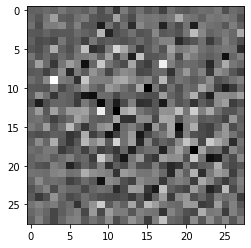

In [29]:
imagem_gerada = gerador(ruido,training =False)
plt.imshow(imagem_gerada[0,:,:,0],cmap='gray')

## Construção do Discriminador

In [32]:
def cria_discriminador():
    network = tf.keras.Sequential()
    
    network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    network.add(layers.Conv2D(filters=128,strides=(2,2),kernel_size=(5,5),padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))    
    
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    network.summary()
    return network

In [33]:
discriminador = cria_discriminador()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [34]:
discriminador(imagem_gerada,training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00317713]], dtype=float32)>

# Calculo do Erro

In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [79]:
def discriminador_loss(expected_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output),expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [72]:
def gerador_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [73]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Treinamento

In [74]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [81]:
#@tf.function
def treinamento(imagens):
    ruido = tf.random.normal([batch_size,dimensao_ruido])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        imagens_geradas = gerador(ruido,training= True)
    
        expected_output = discriminador(imagens, training = True)
        fake_output = discriminador(imagens_geradas,training=True)
        
        gen_loss = gerador_loss(fake_output)
        disc_loss = discriminador_loss(expected_output, fake_output)
        
    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradentes_discriminador = disc_tape.gradient(disc_loss,discriminador.trainable_variables)
    
    gerador_optimizer.apply_gradients(zip(gradientes_gerador,gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradentes_discriminador,discriminador.trainable_variables))

In [76]:
imagens_teste = tf.random.normal([numero_imagens,dimensao_ruido])

In [77]:
def treina_gan(dataset, epocas,imagens_teste):
    for epoca in range(epocas):
        for imagem_batch in dataset:
            treinamento(imagem_batch)
            
        print('Epoca: ',epoca+1)
        imagens_geradas = gerador(imagens_teste,training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(imagens_geradas.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(imagens_geradas[i,:,:,0]*127.5 +127.5,cmap='gray')
            plt.axis('off')
        plt.show()

Epoca:  1


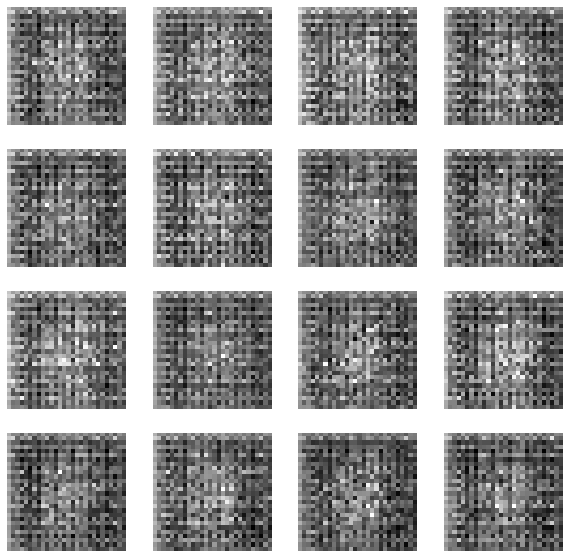

Epoca:  2


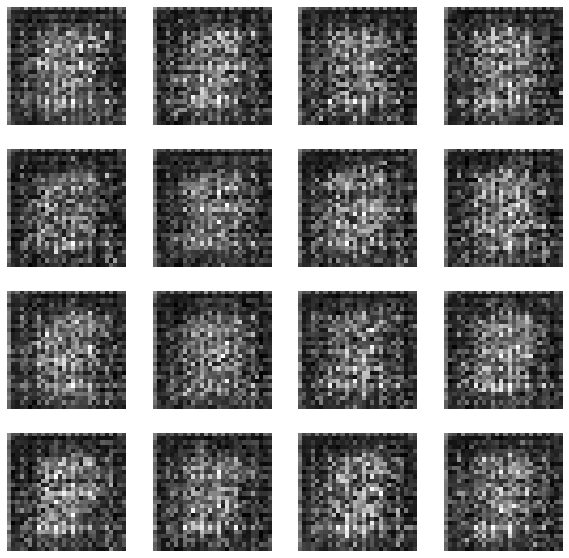

Epoca:  3


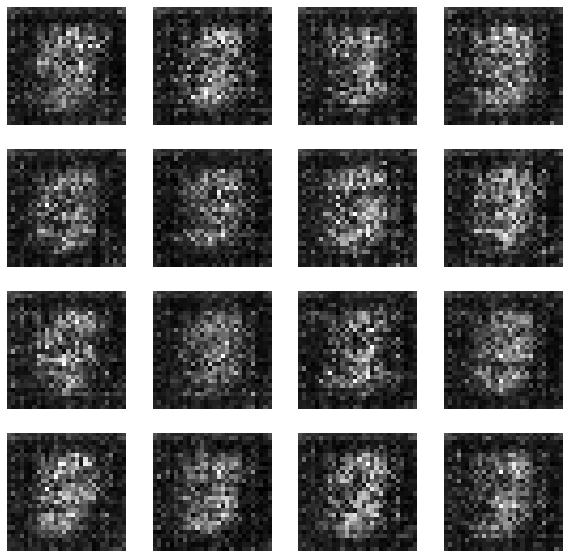

Epoca:  4


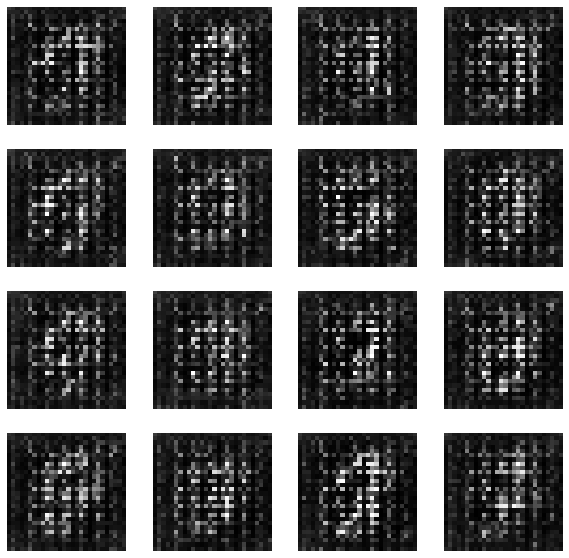

Epoca:  5


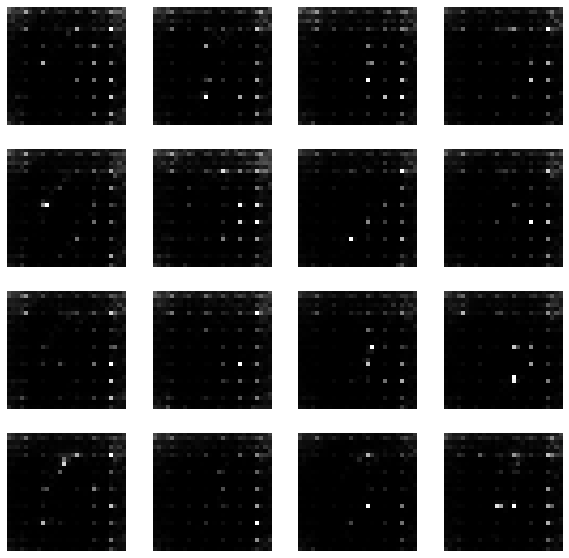

Epoca:  6


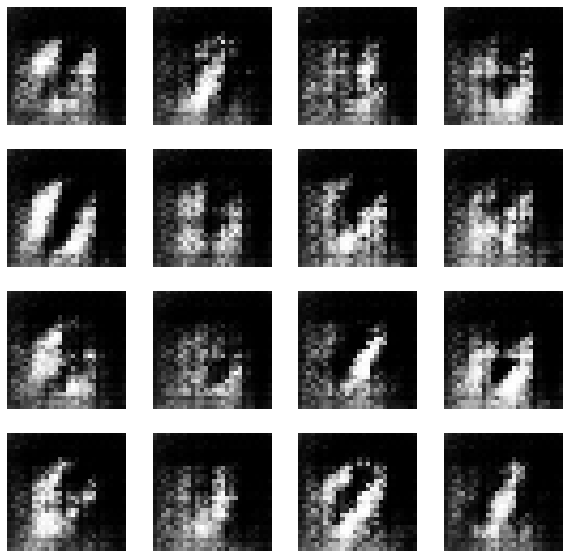

Epoca:  7


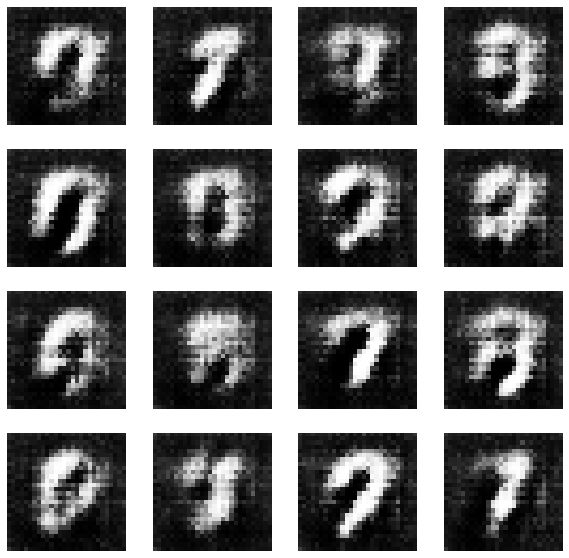

Epoca:  8


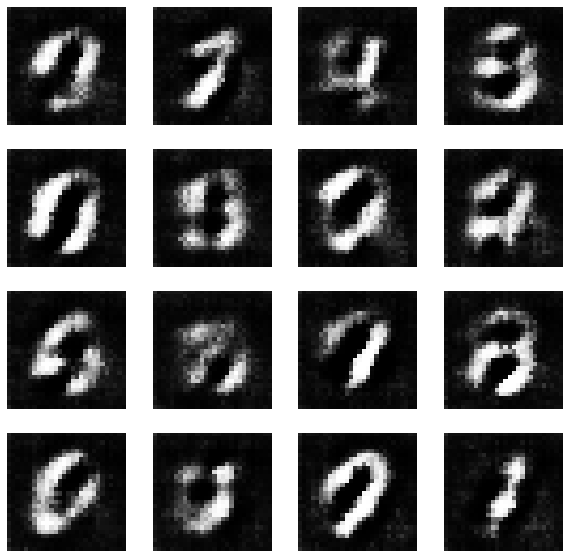

Epoca:  9


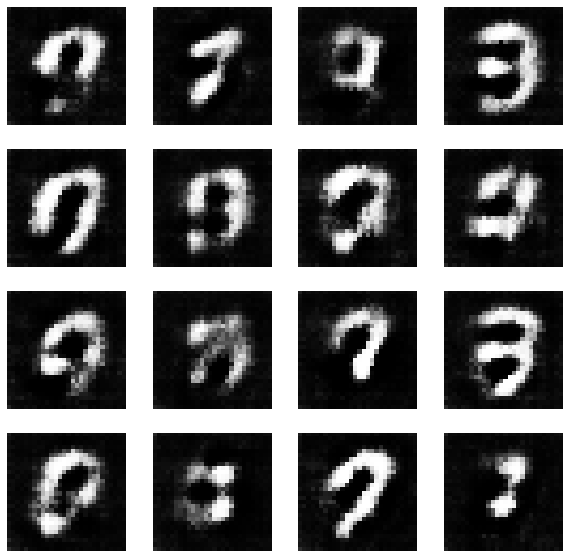

Epoca:  10


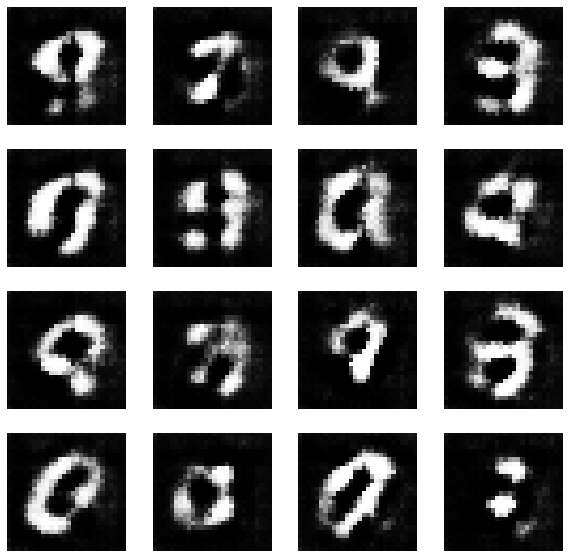

Epoca:  11


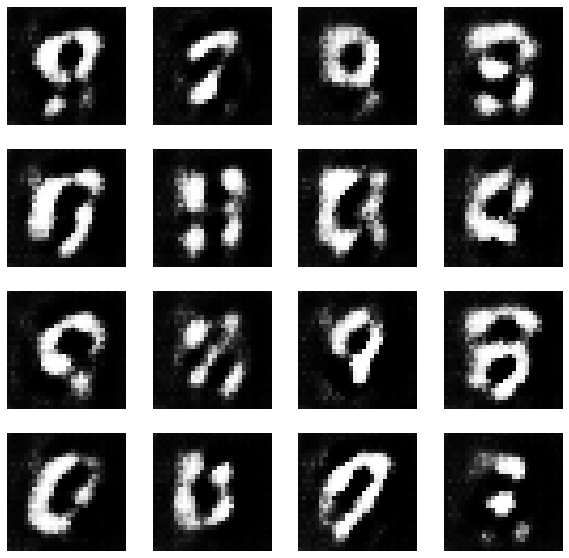

Epoca:  12


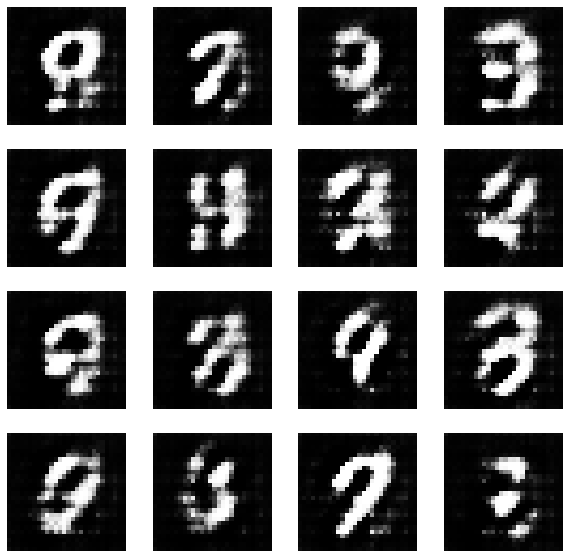

Epoca:  13


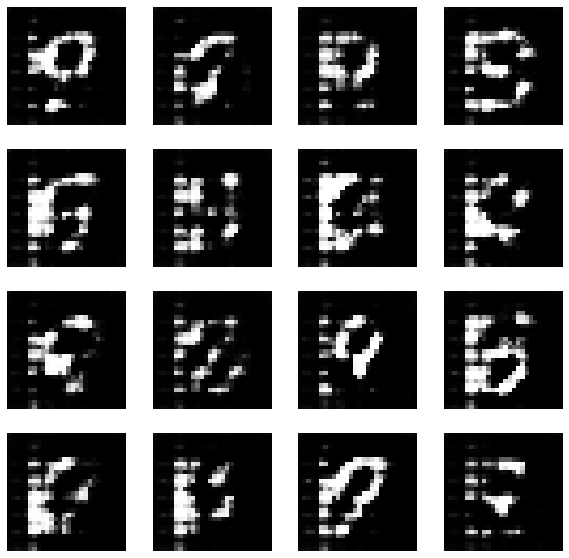

Epoca:  14


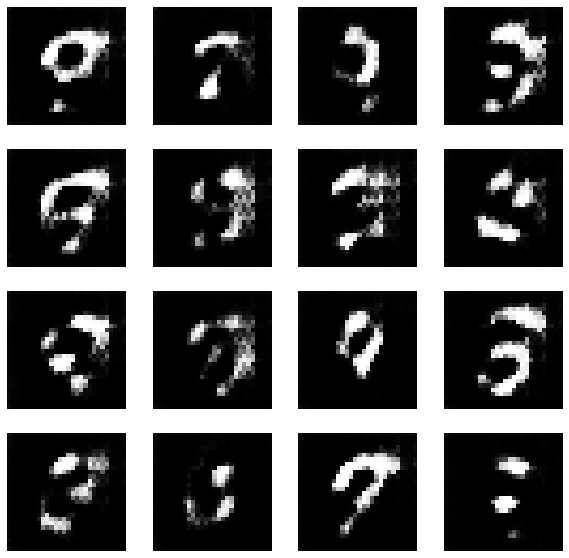

Epoca:  15


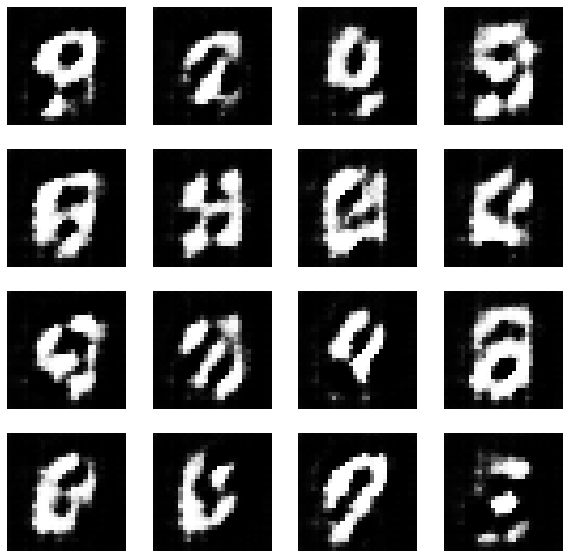

Epoca:  16


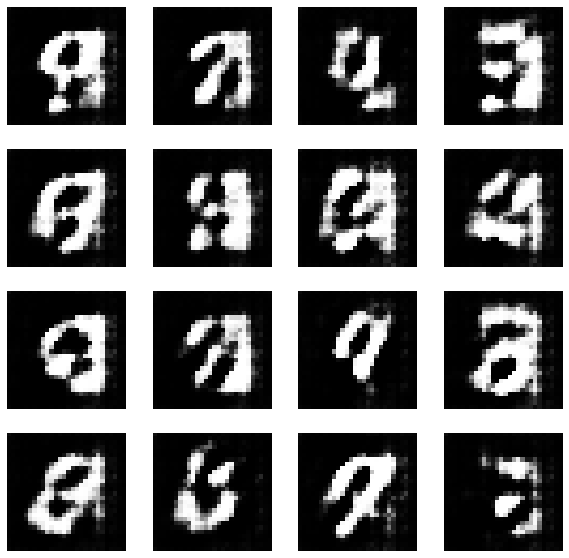

Epoca:  17


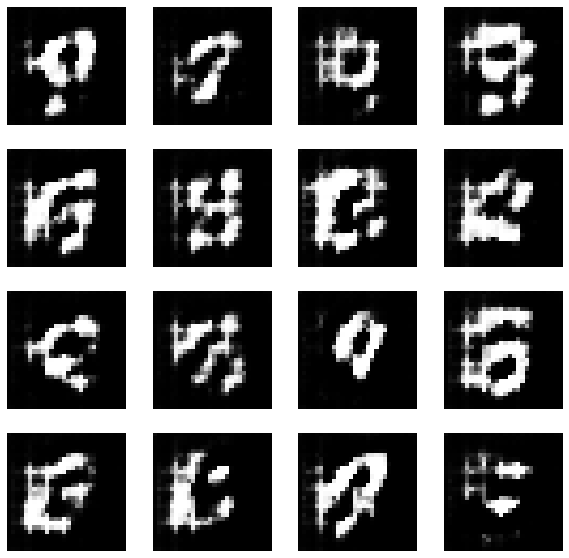

Epoca:  18


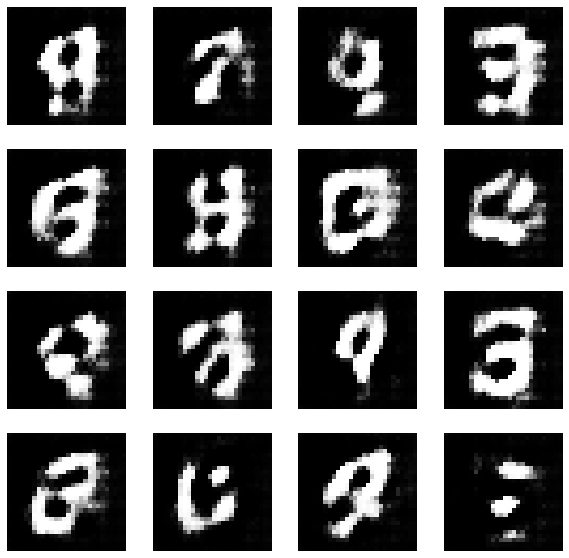

Epoca:  19


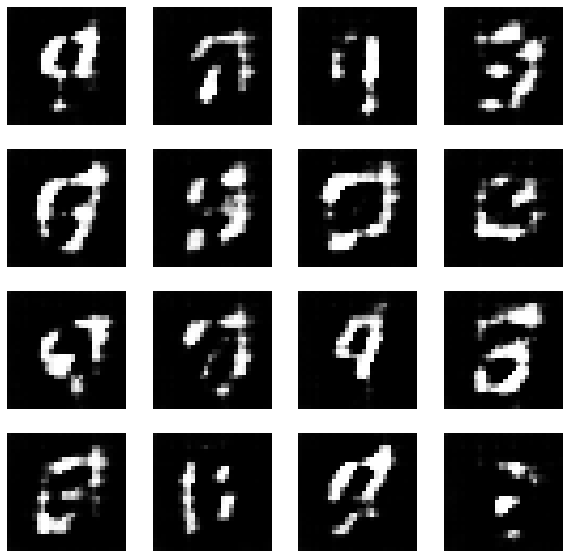

Epoca:  20


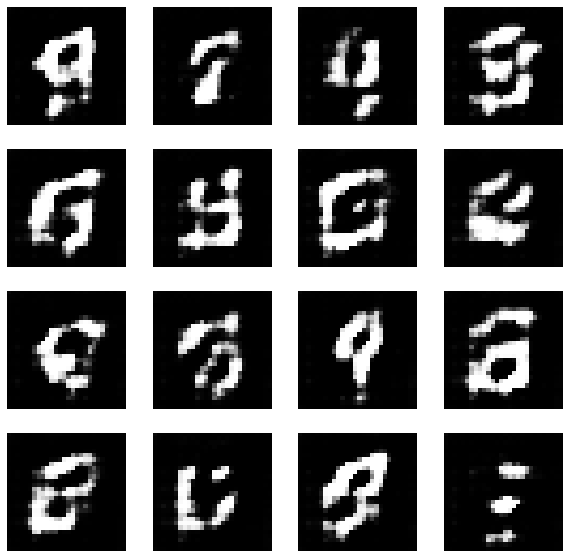

Epoca:  21


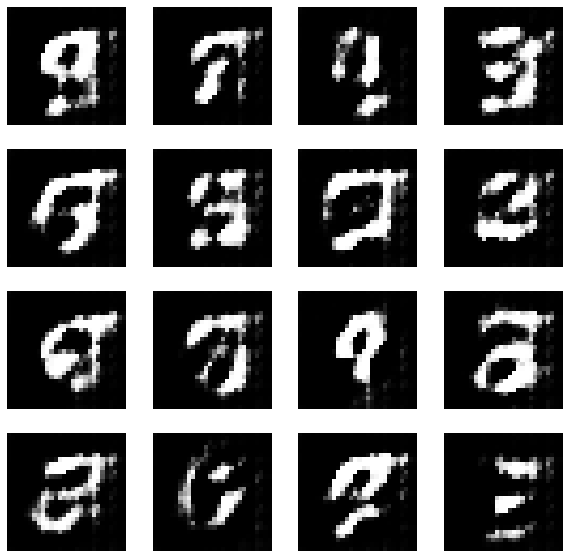

Epoca:  22


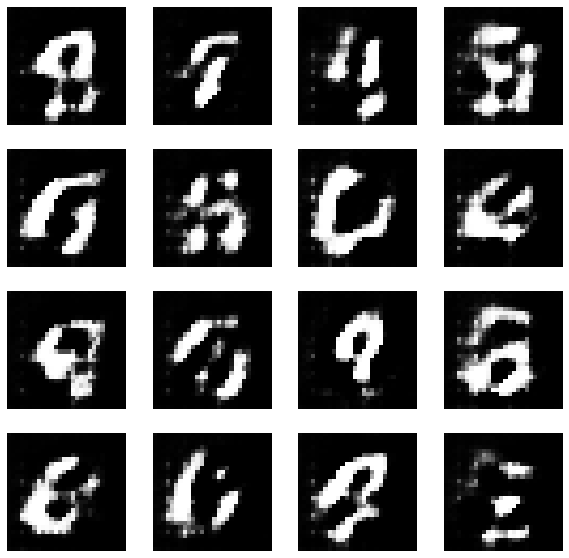

Epoca:  23


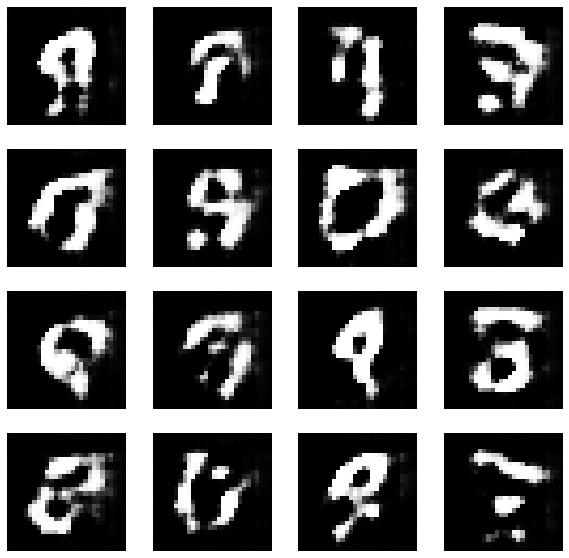

Epoca:  24


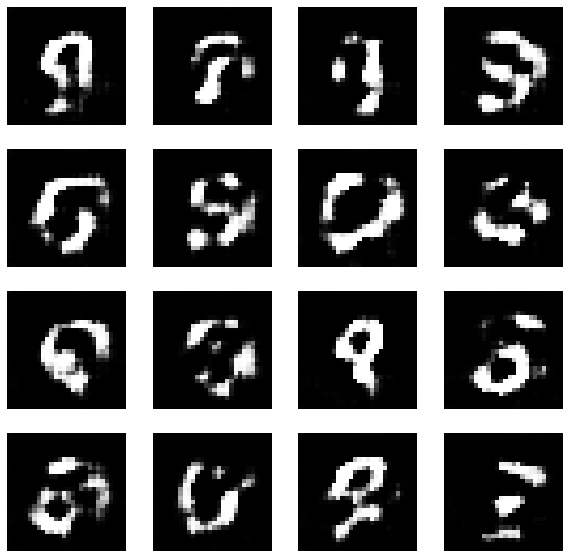

Epoca:  25


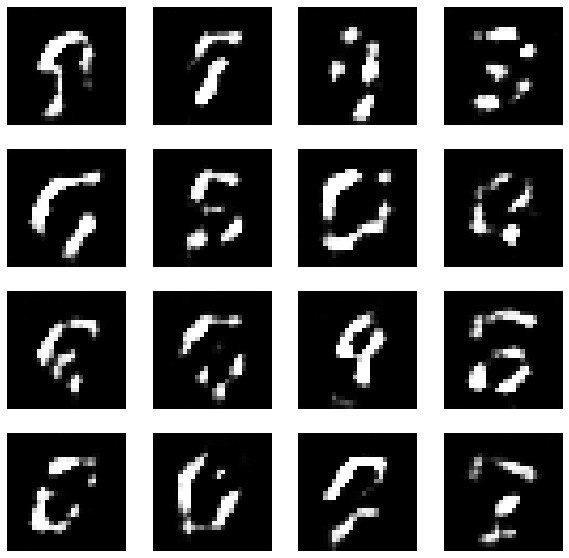

Epoca:  26


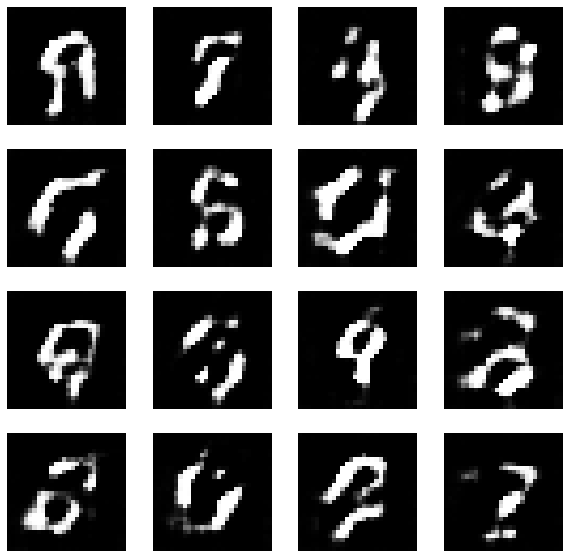

Epoca:  27


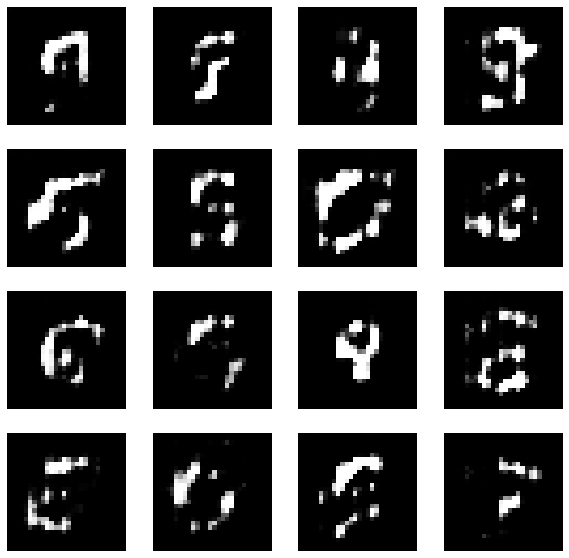

Epoca:  28


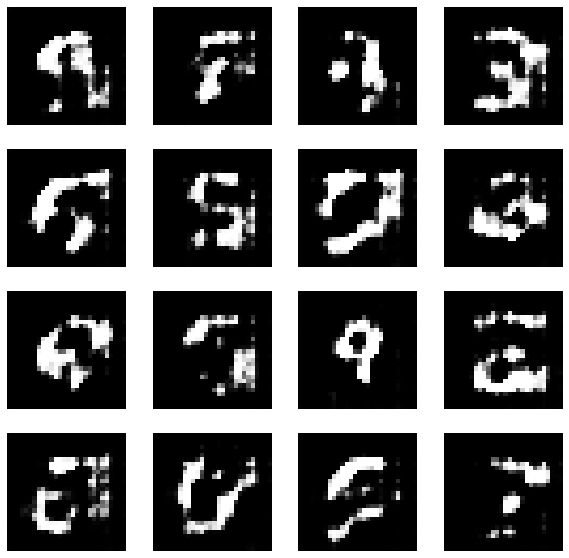

Epoca:  29


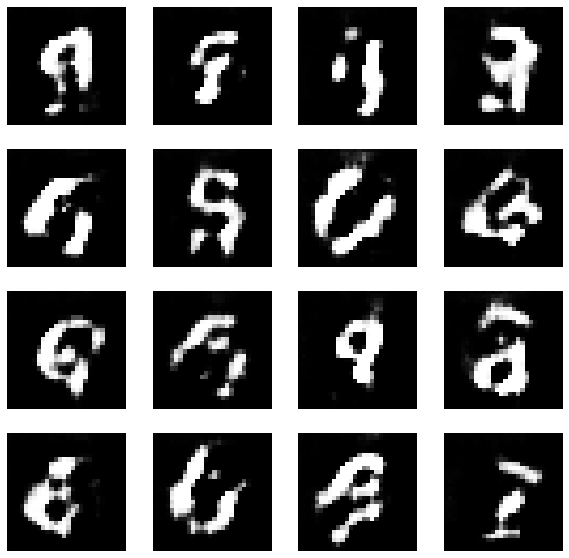

Epoca:  30


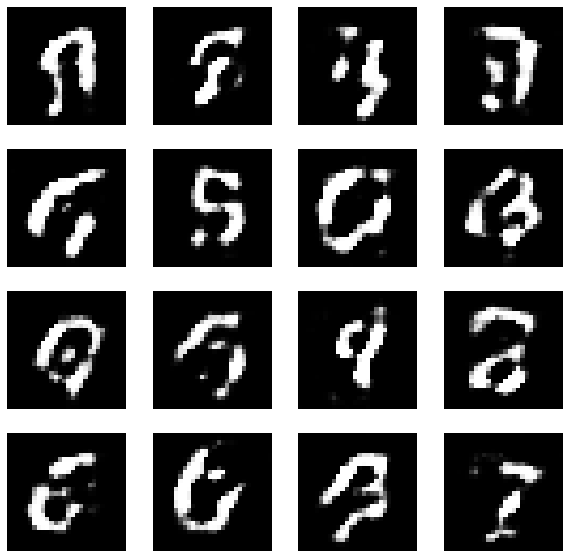

Epoca:  31


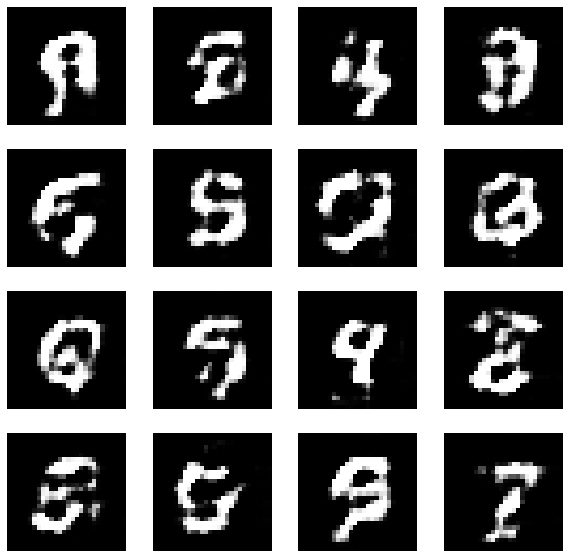

Epoca:  32


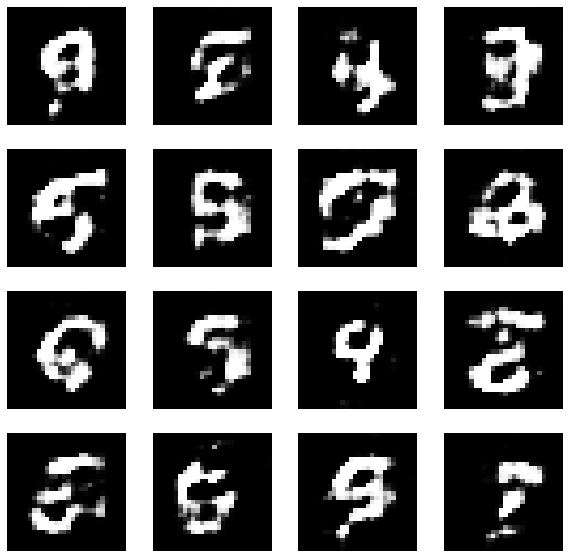

Epoca:  33


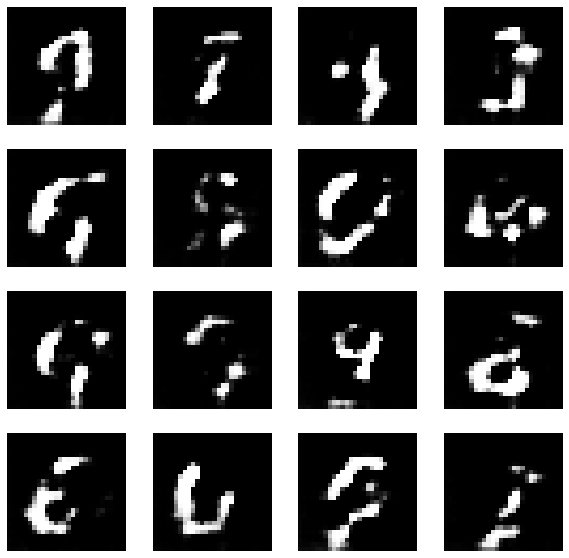

Epoca:  34


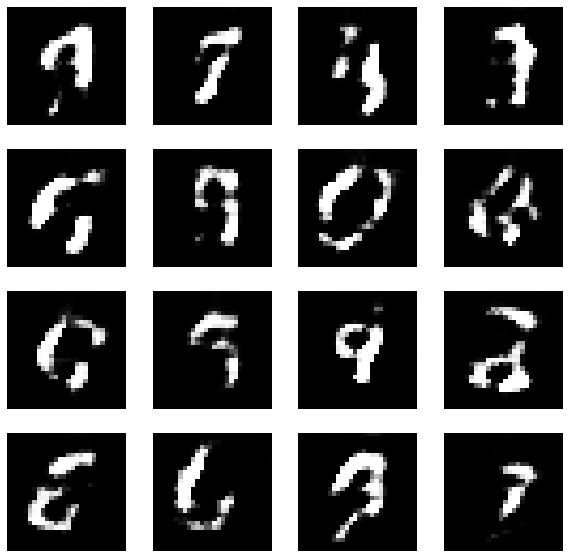

Epoca:  35


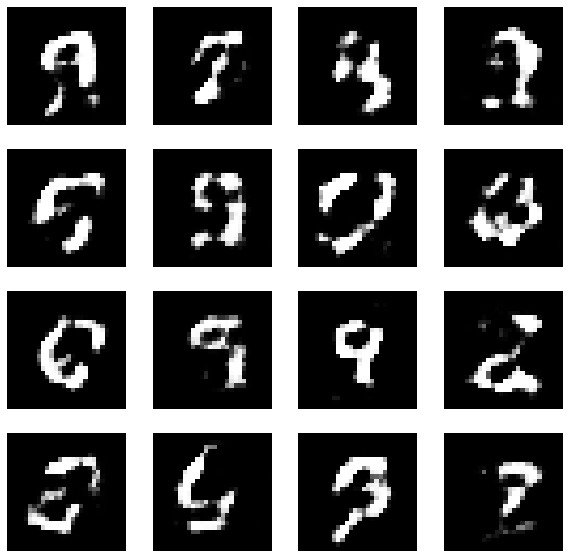

Epoca:  36


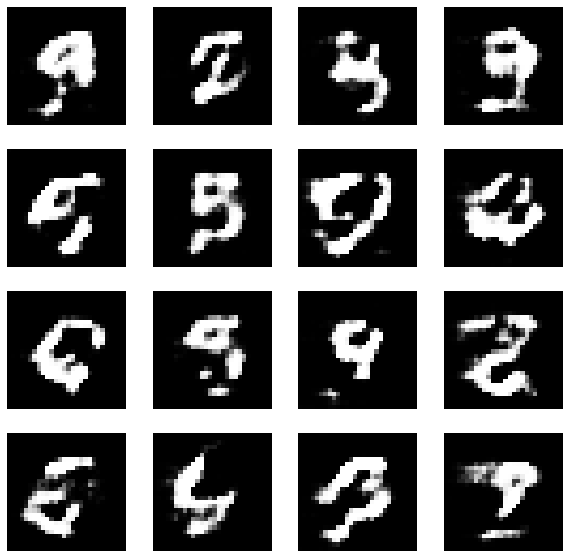

Epoca:  37


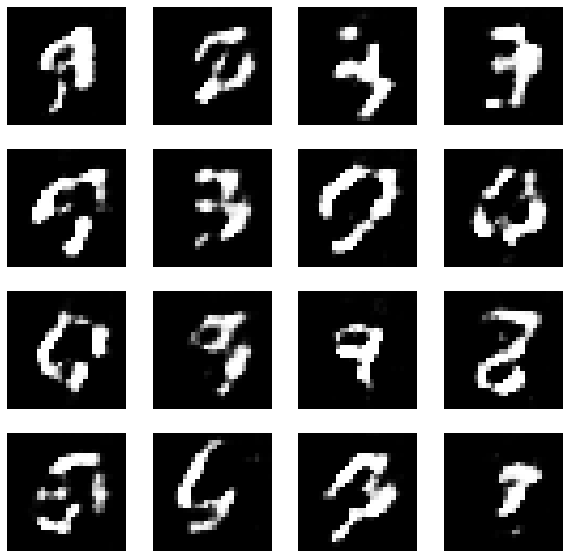

Epoca:  38


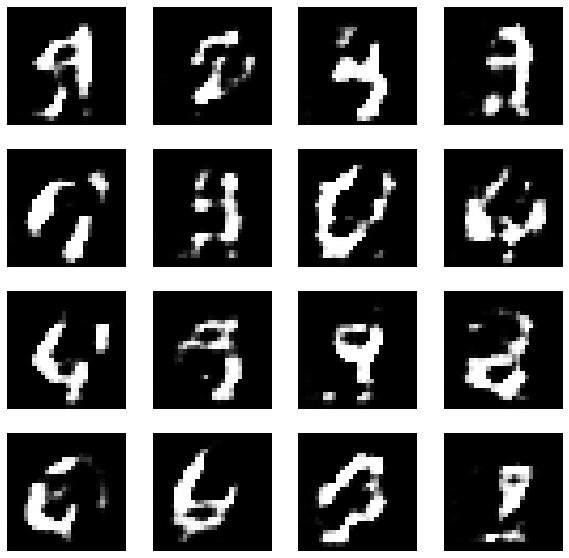

Epoca:  39


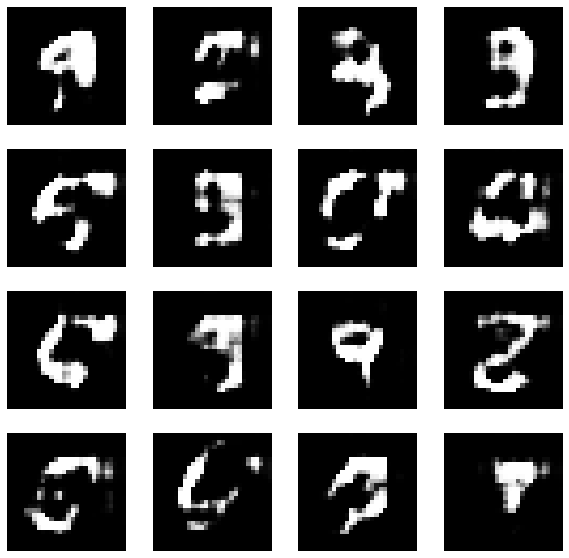

Epoca:  40


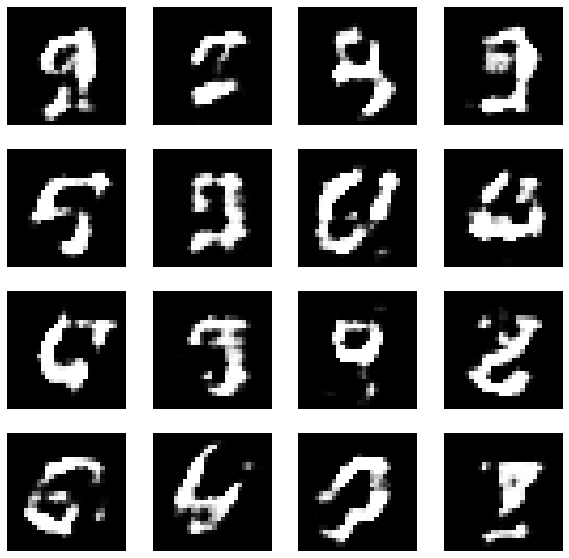

Epoca:  41


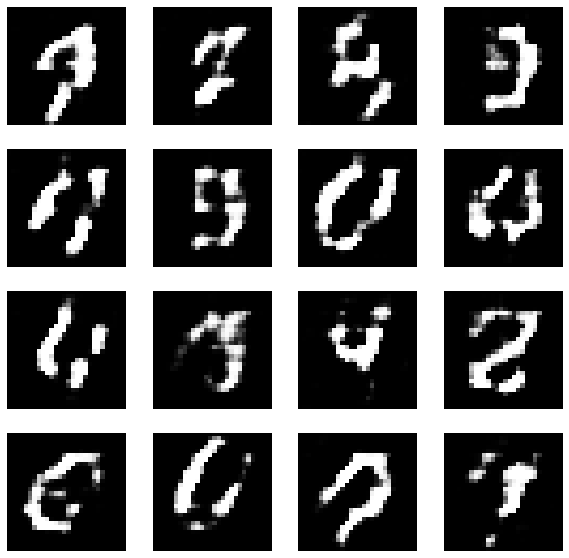

Epoca:  42


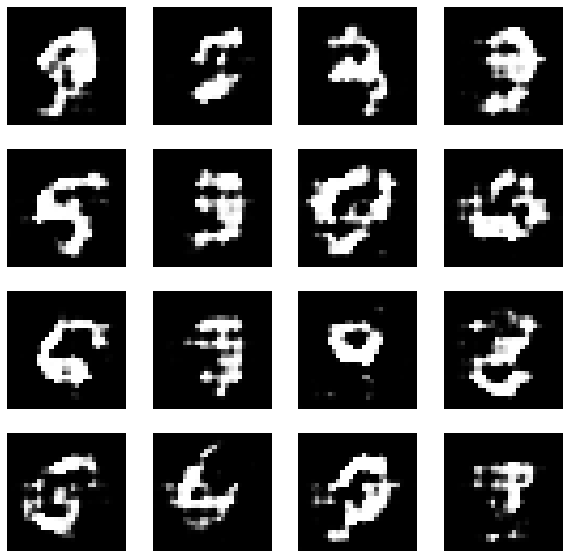

Epoca:  43


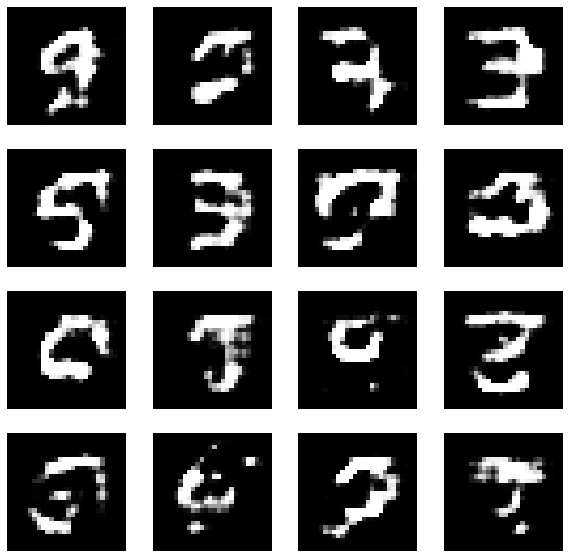

Epoca:  44


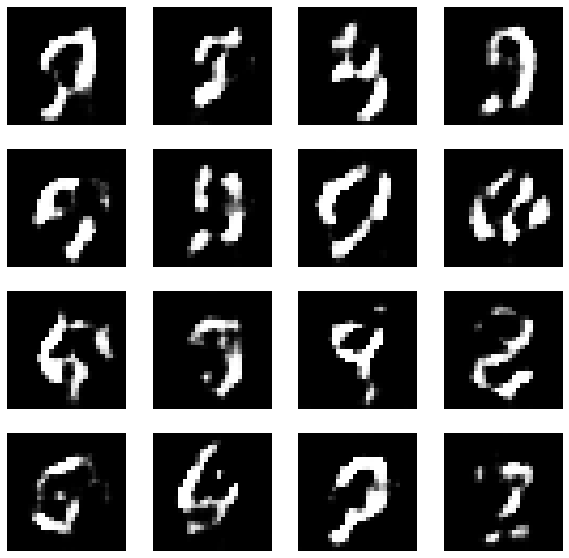

Epoca:  45


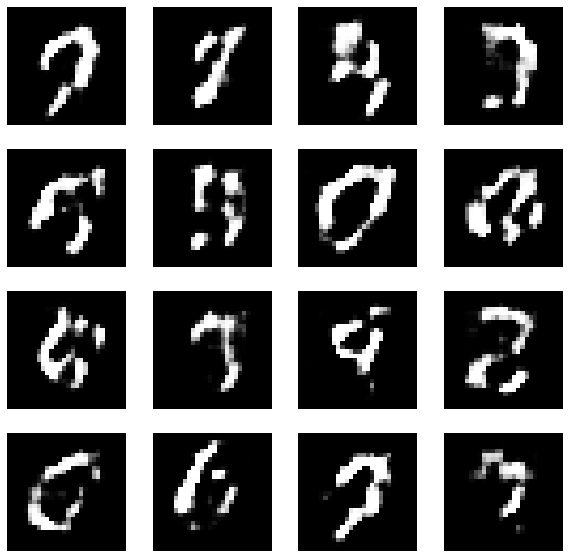

Epoca:  46


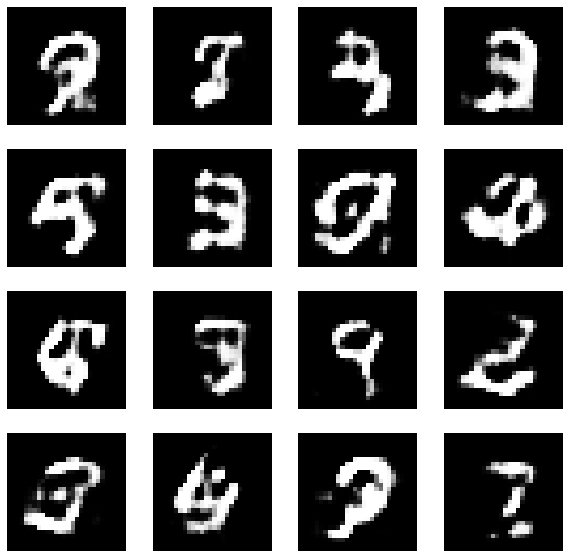

Epoca:  47


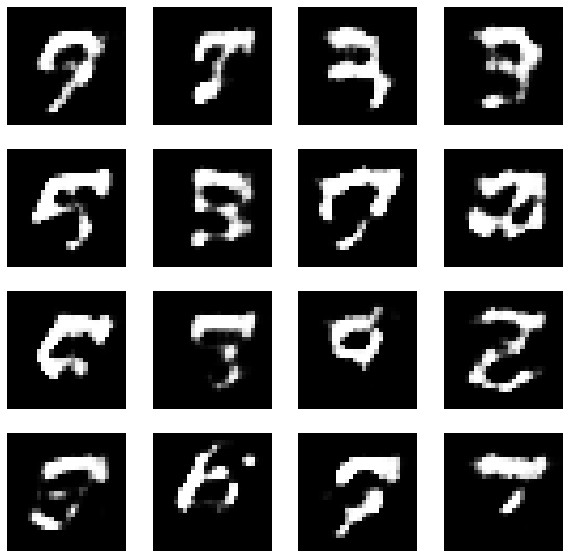

Epoca:  48


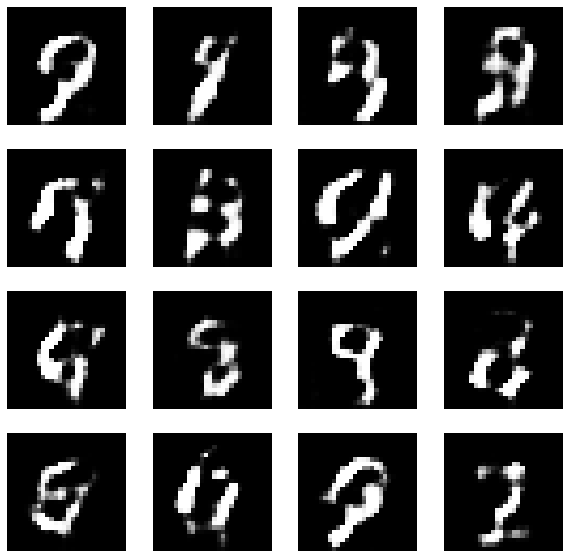

Epoca:  49


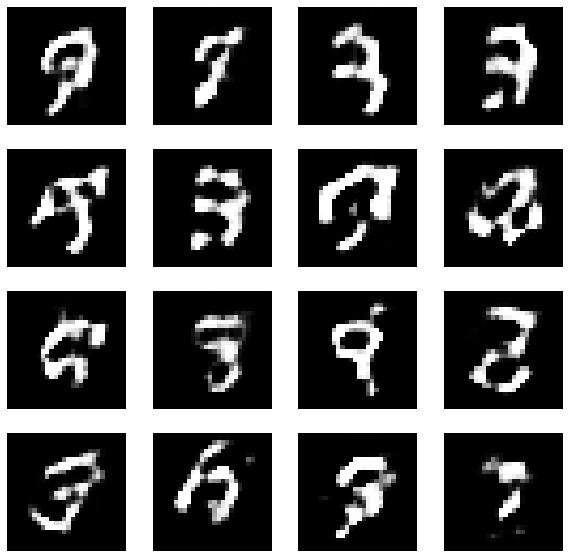

Epoca:  50


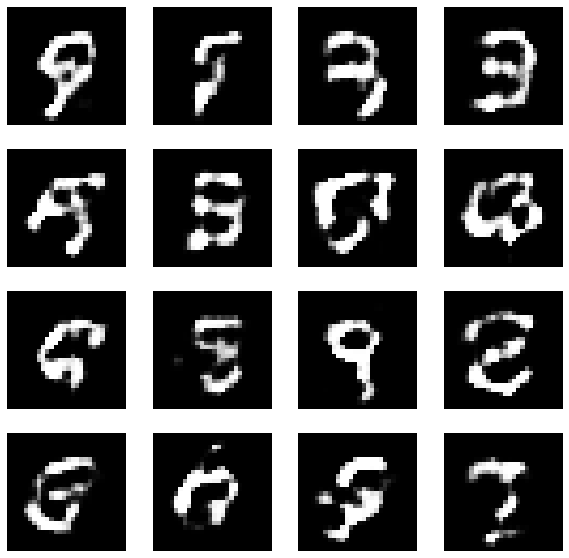

Epoca:  51


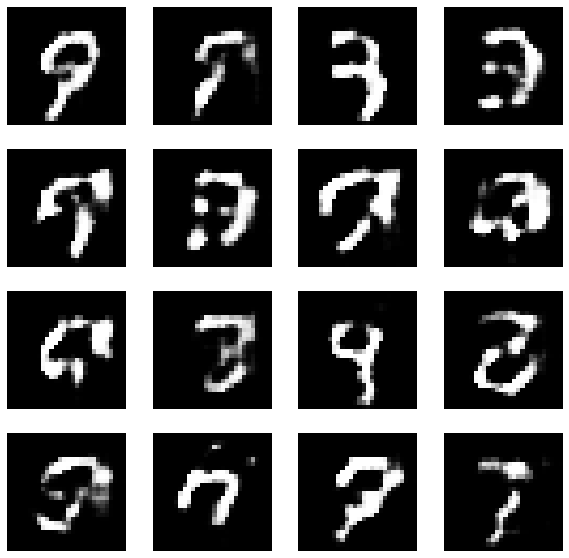

Epoca:  52


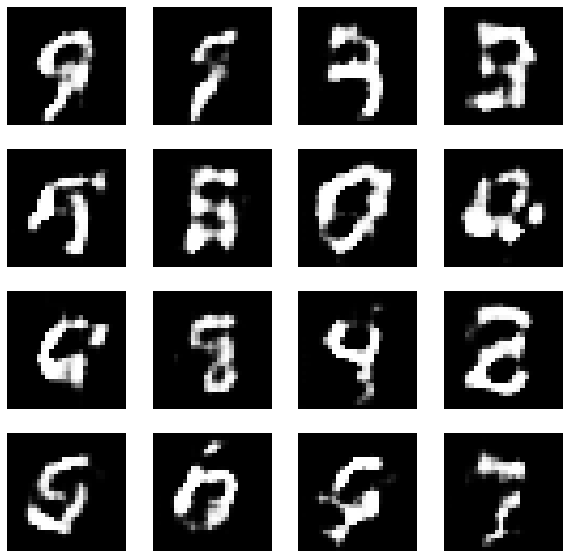

Epoca:  53


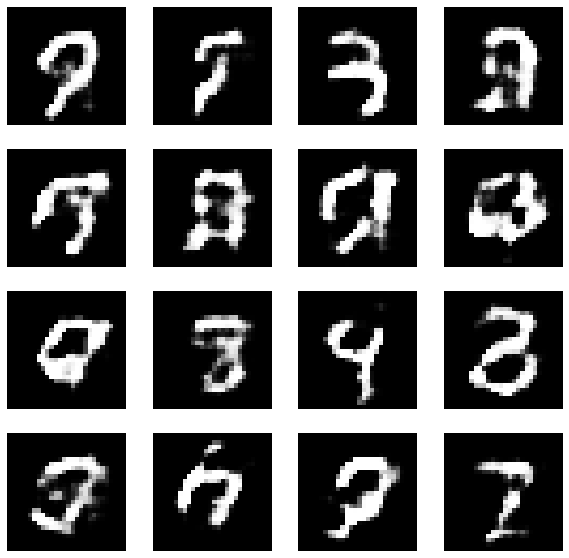

Epoca:  54


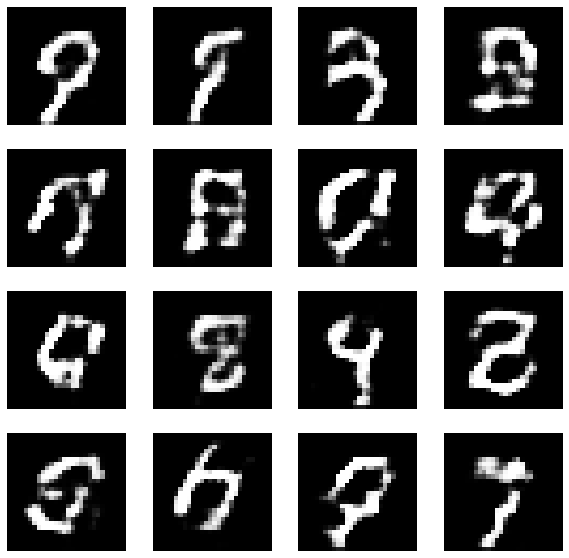

Epoca:  55


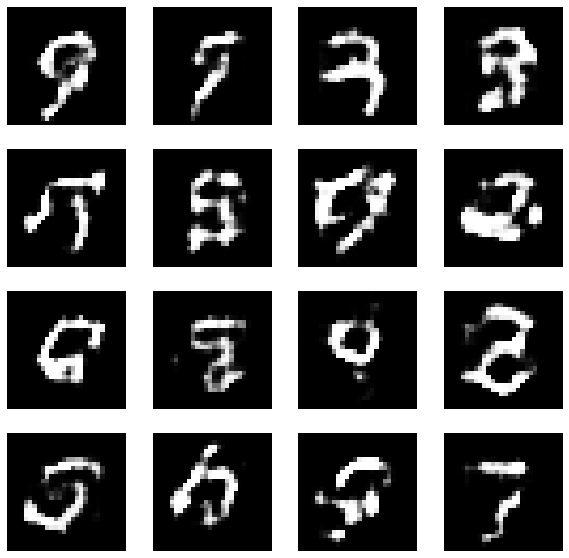

Epoca:  56


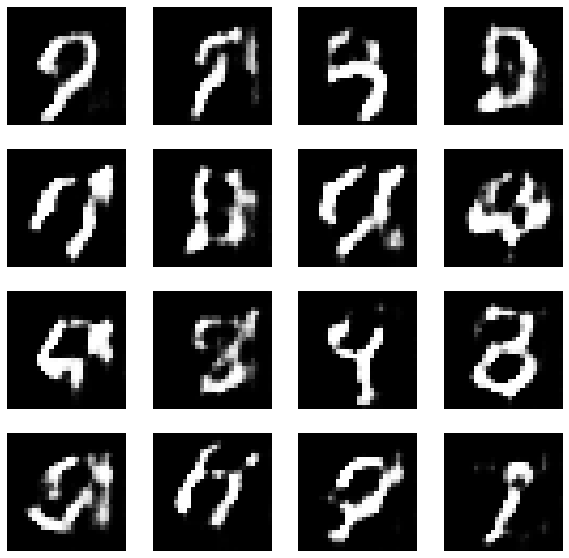

Epoca:  57


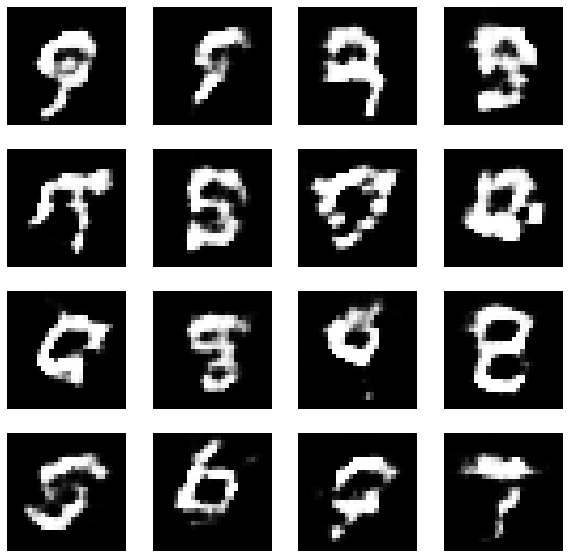

Epoca:  58


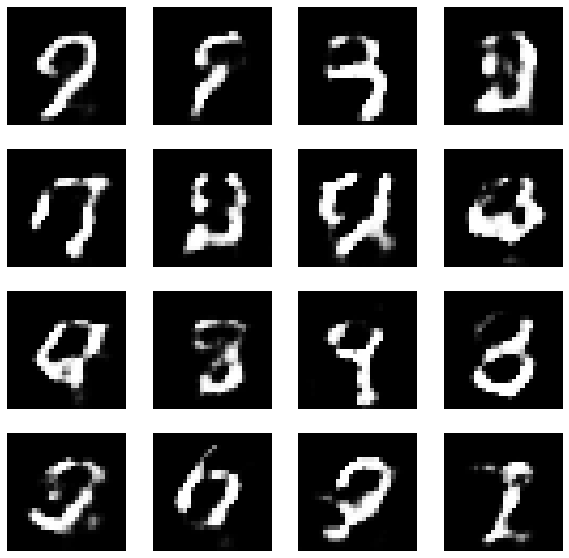

Epoca:  59


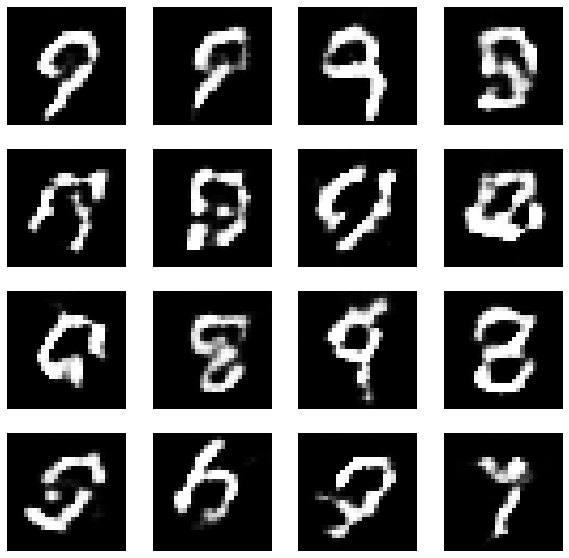

Epoca:  60


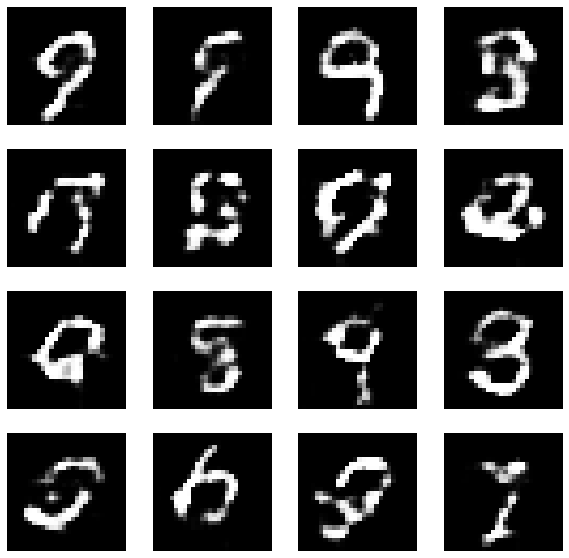

Epoca:  61


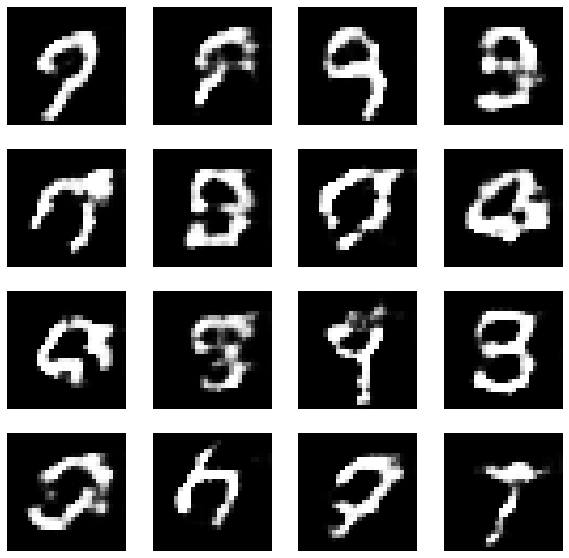

Epoca:  62


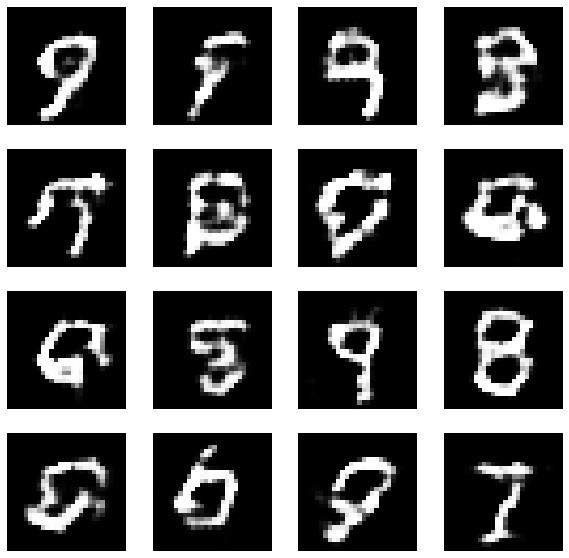

Epoca:  63


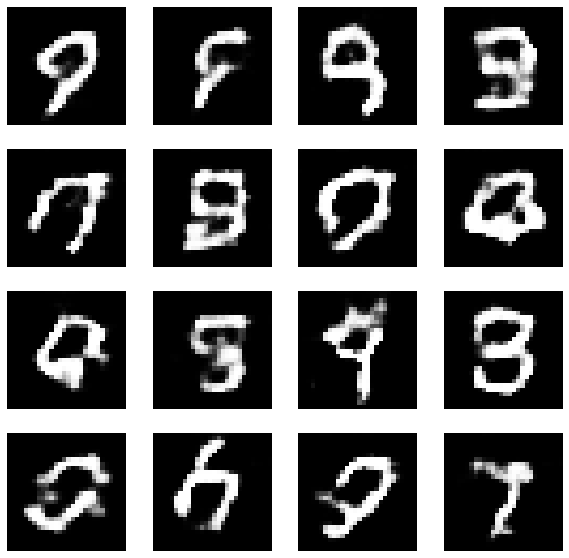

Epoca:  64


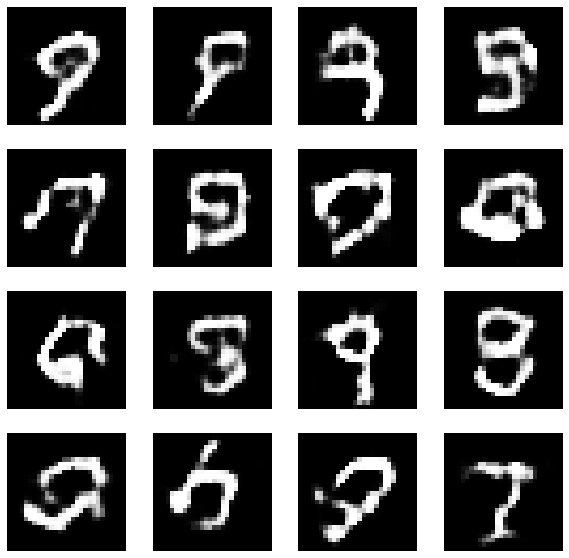

Epoca:  65


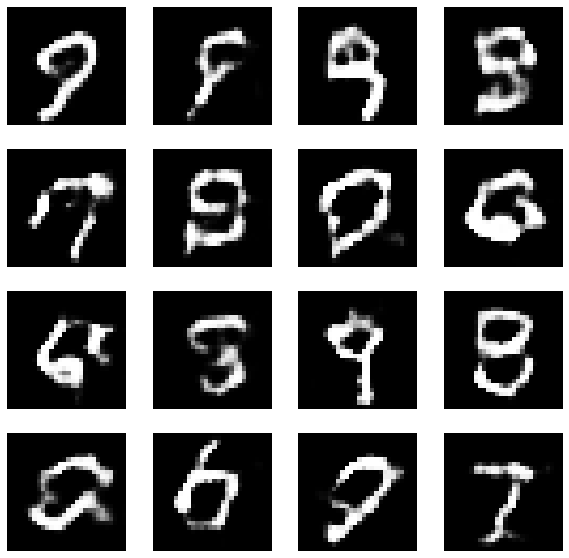

Epoca:  66


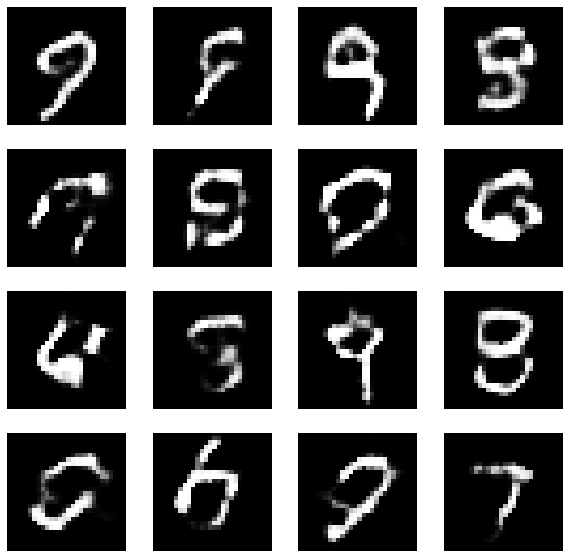

Epoca:  67


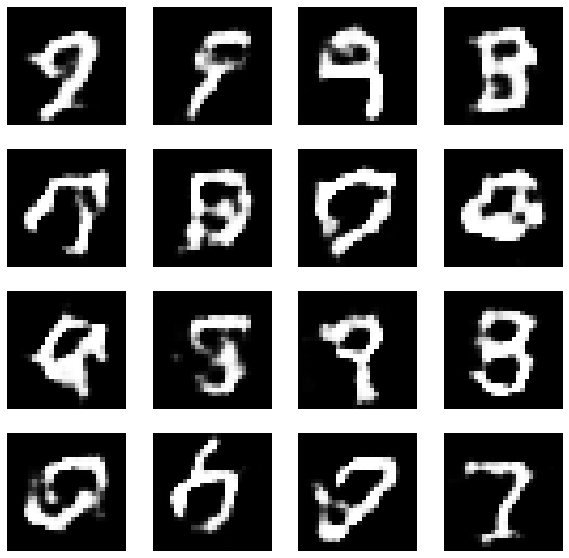

Epoca:  68


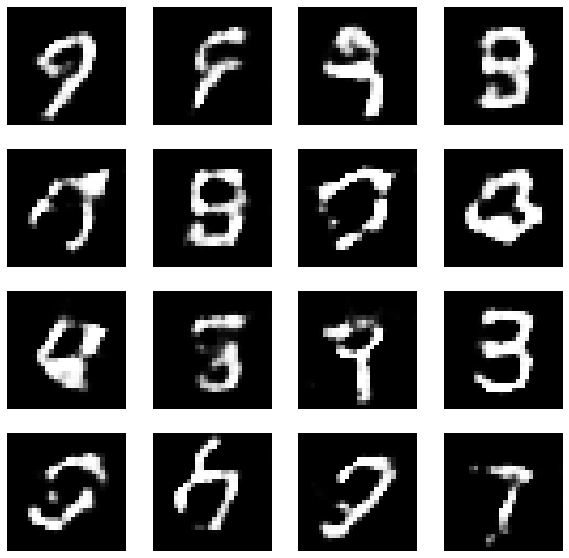

Epoca:  69


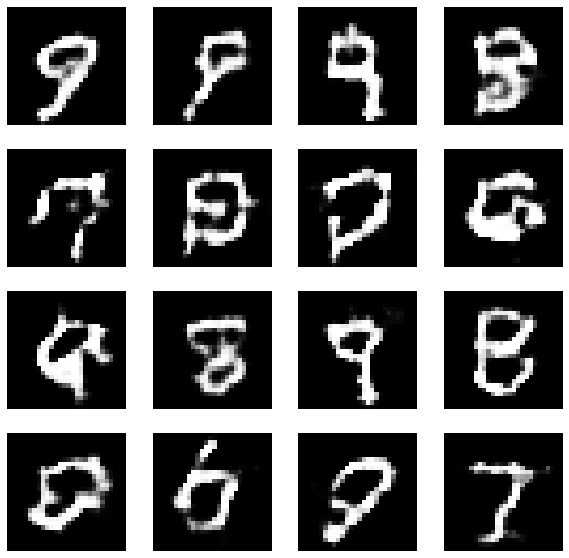

Epoca:  70


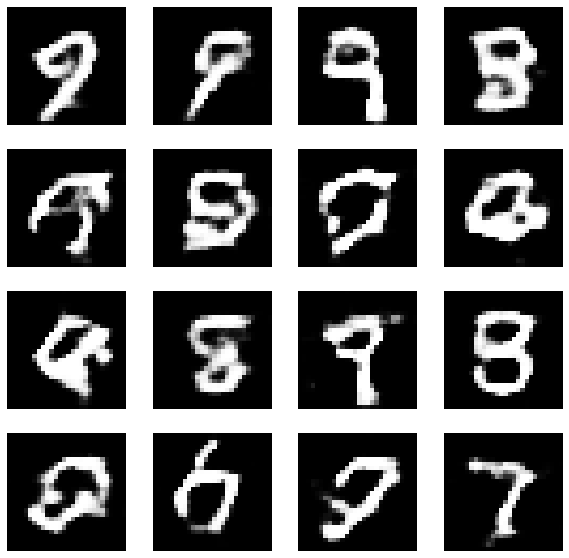

Epoca:  71


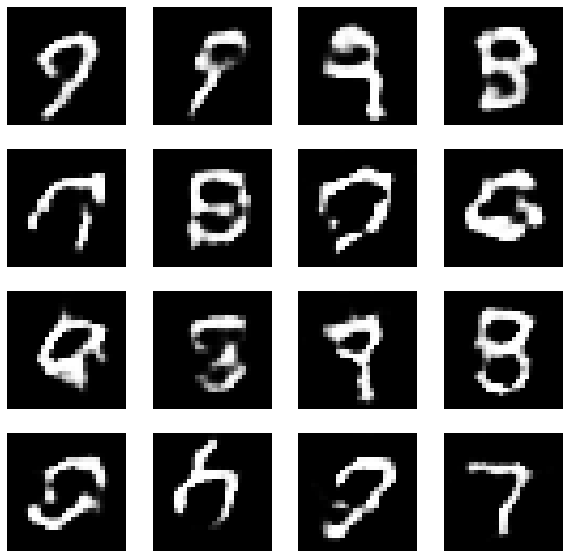

Epoca:  72


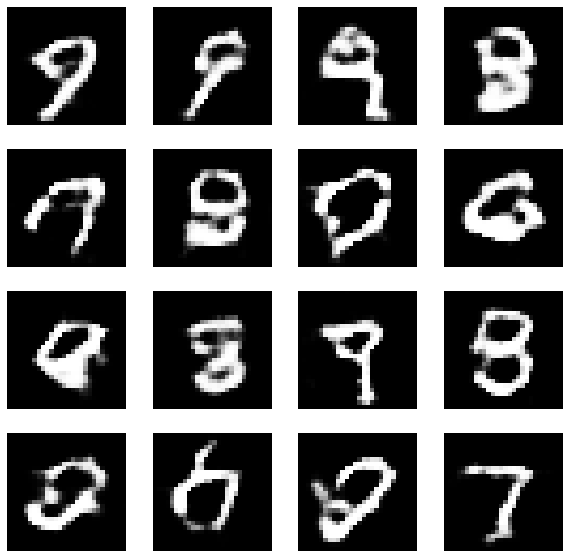

Epoca:  73


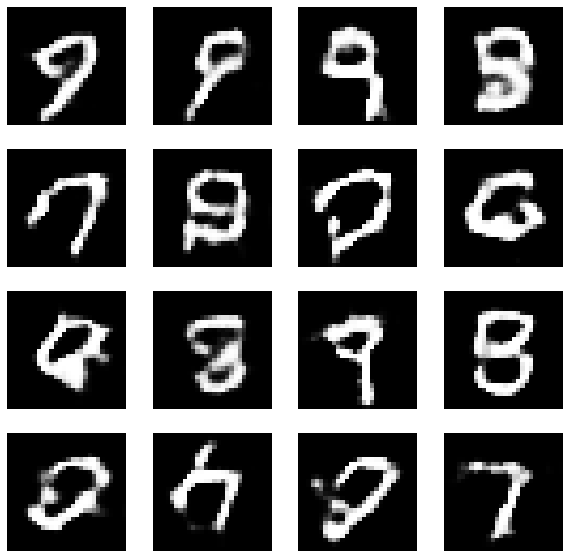

Epoca:  74


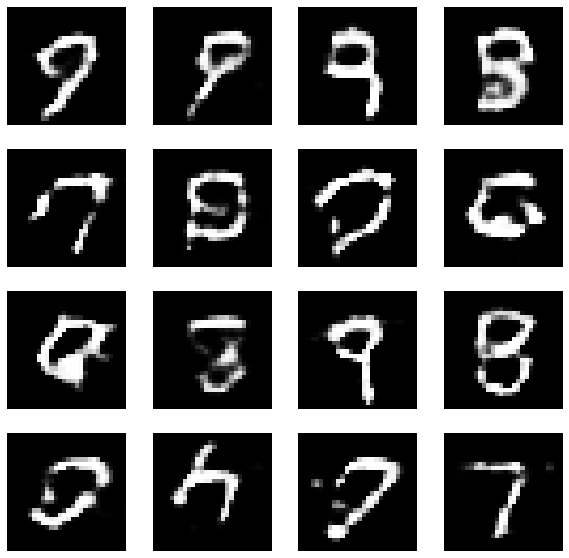

Epoca:  75


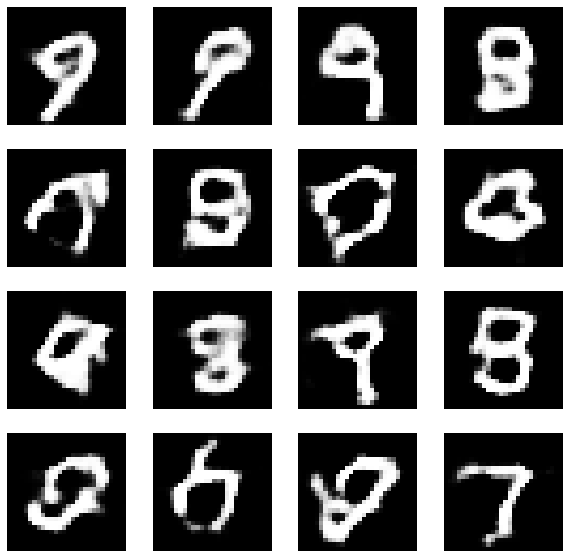

Epoca:  76


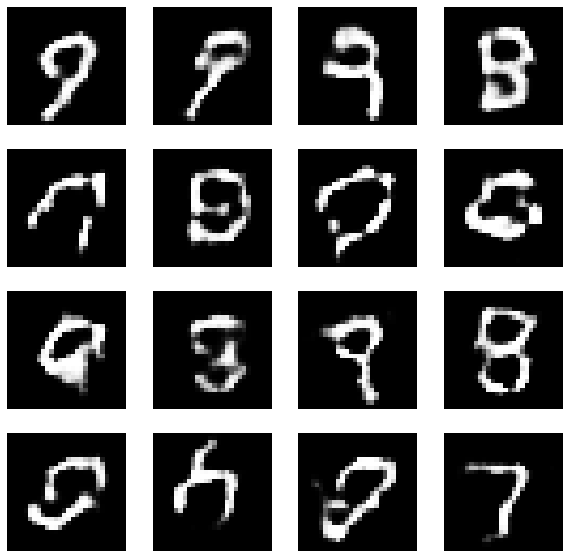

Epoca:  77


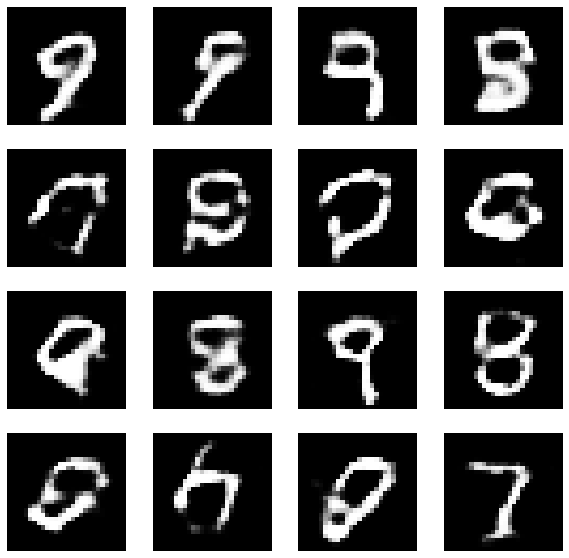

Epoca:  78


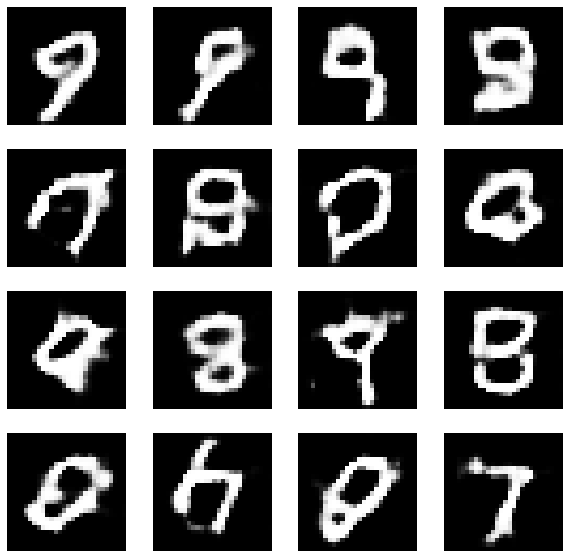

Epoca:  79


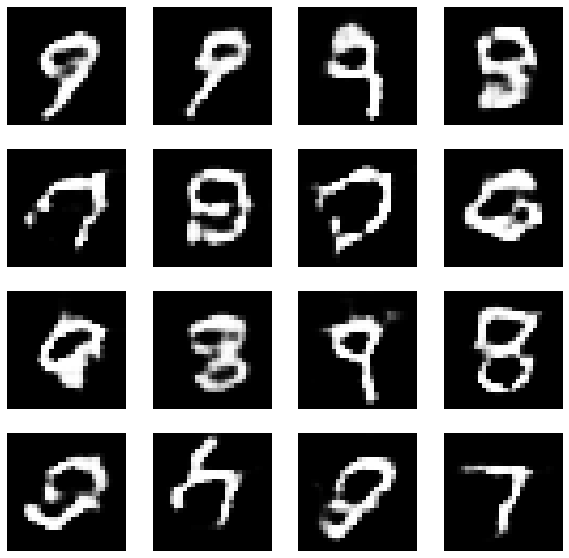

Epoca:  80


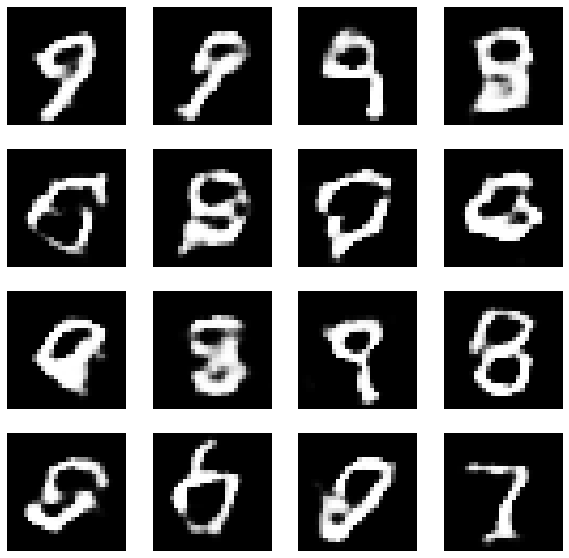

Epoca:  81


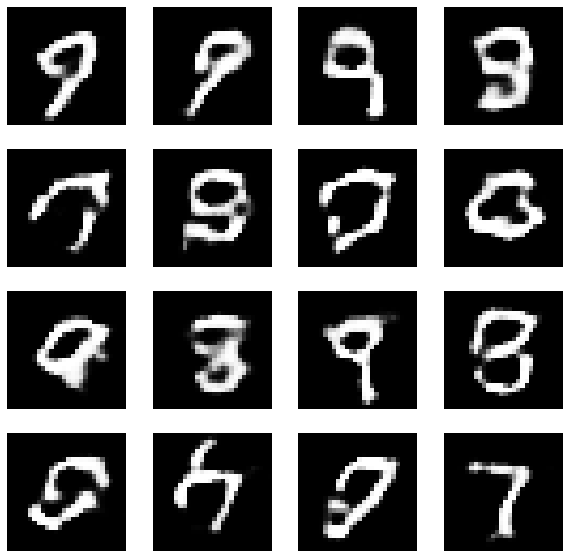

Epoca:  82


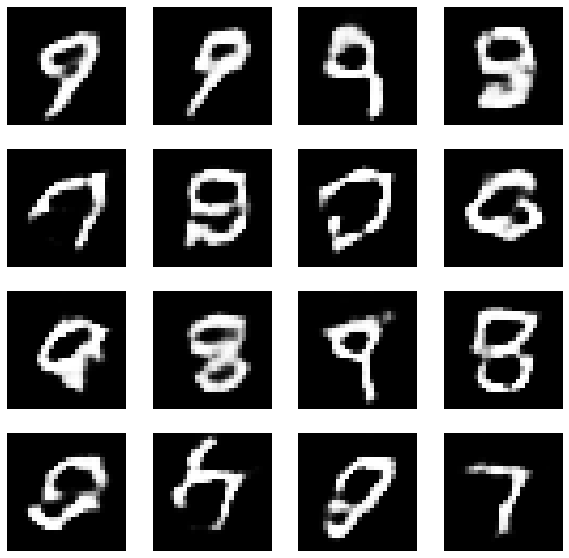

Epoca:  83


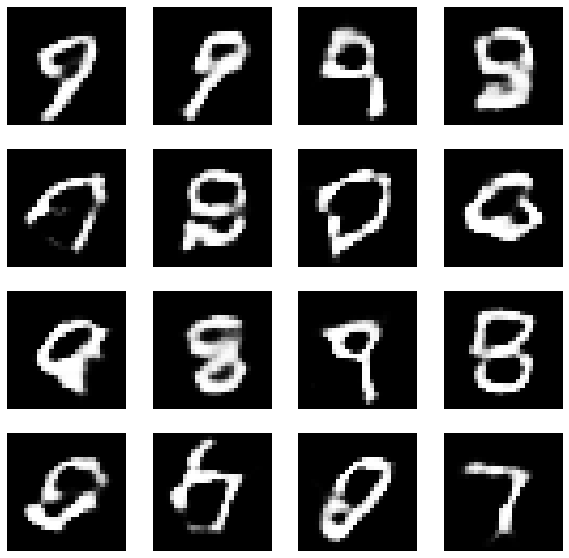

Epoca:  84


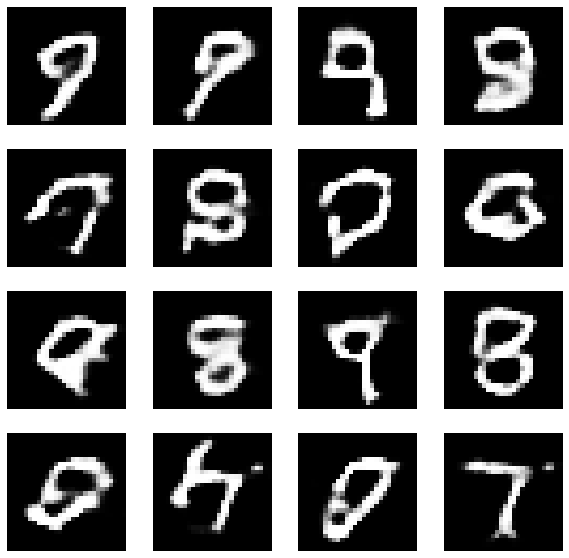

Epoca:  85


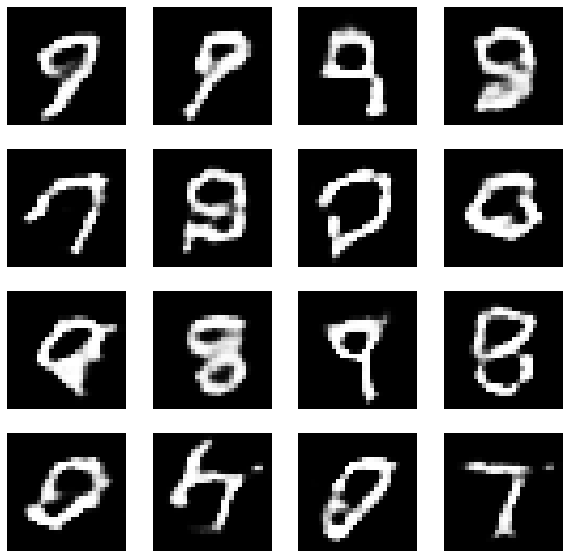

Epoca:  86


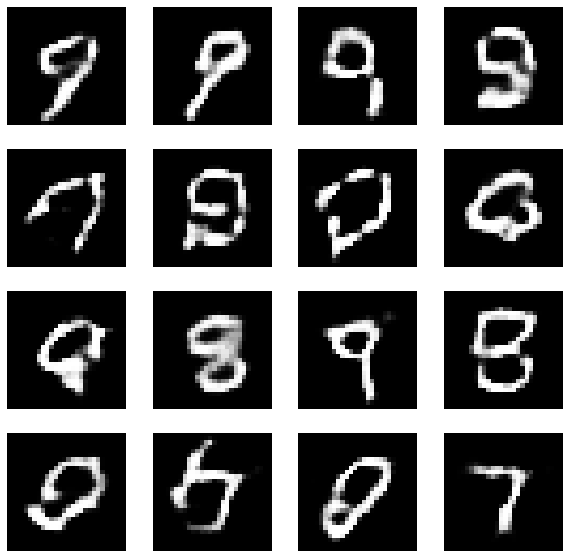

Epoca:  87


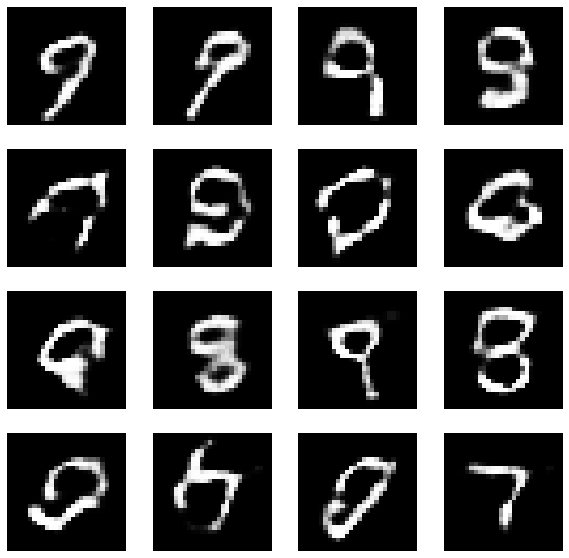

Epoca:  88


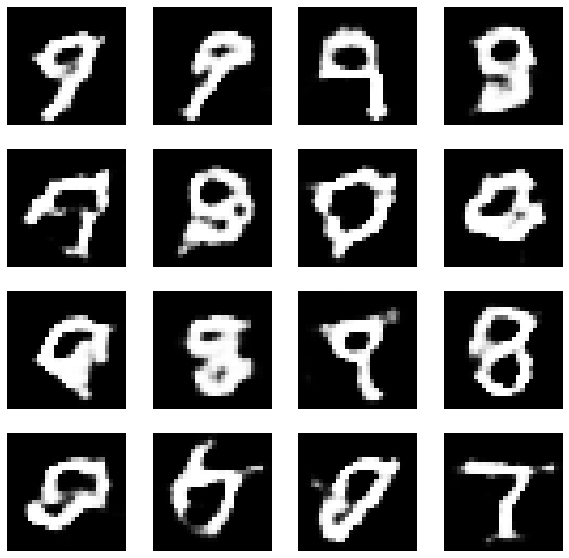

Epoca:  89


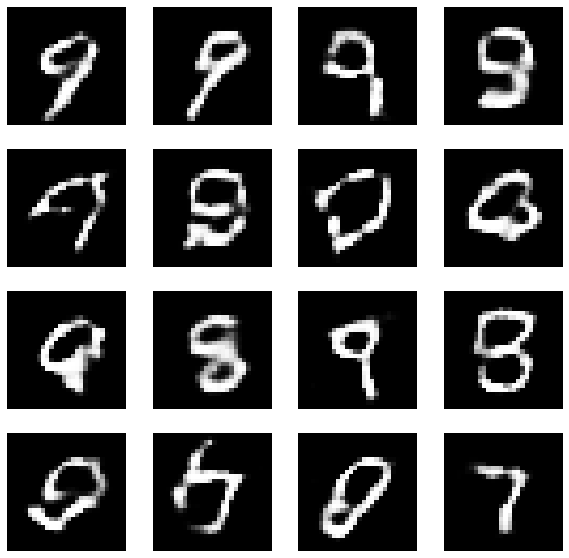

Epoca:  90


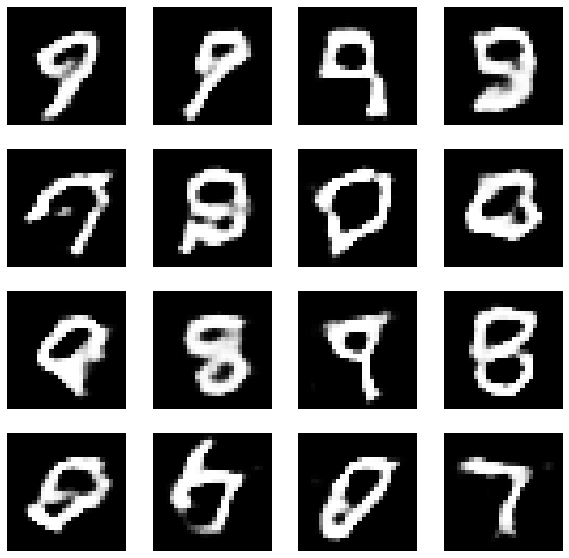

Epoca:  91


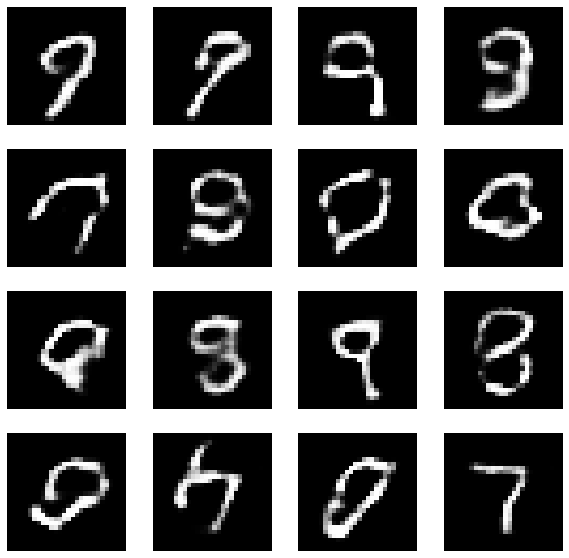

Epoca:  92


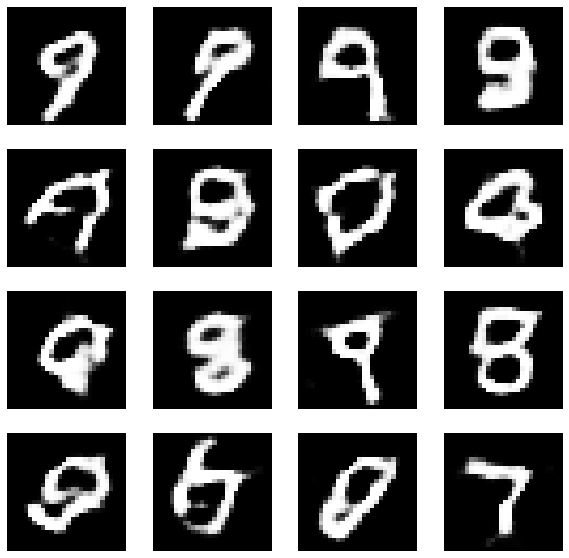

Epoca:  93


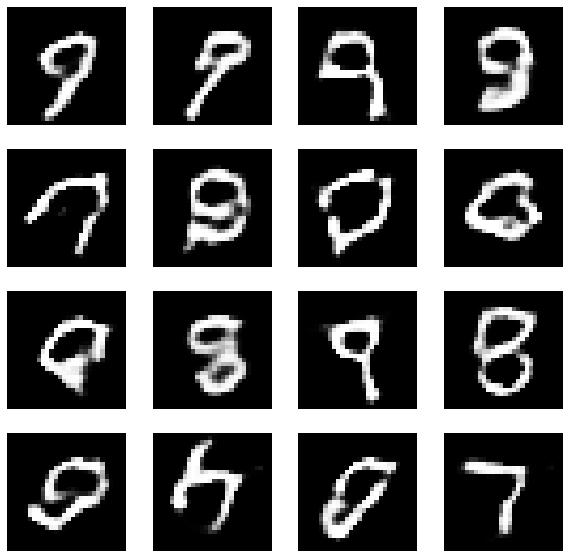

Epoca:  94


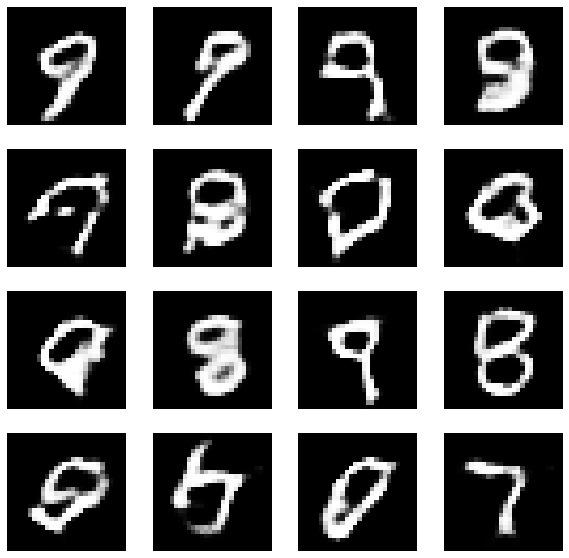

Epoca:  95


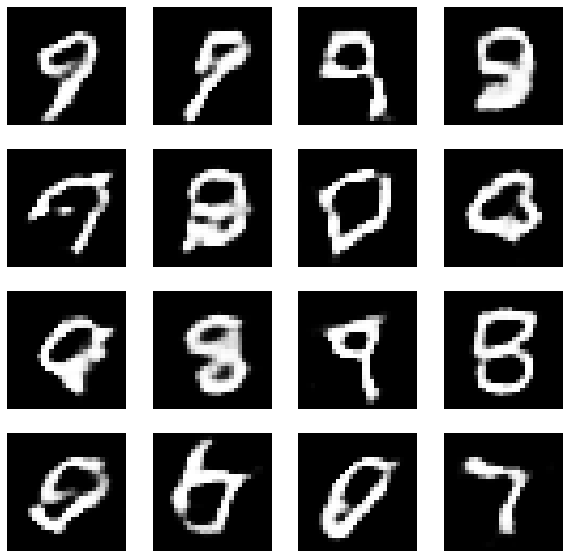

Epoca:  96


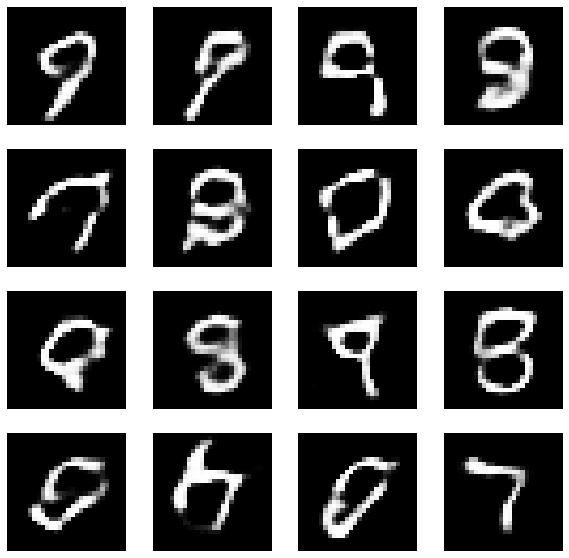

Epoca:  97


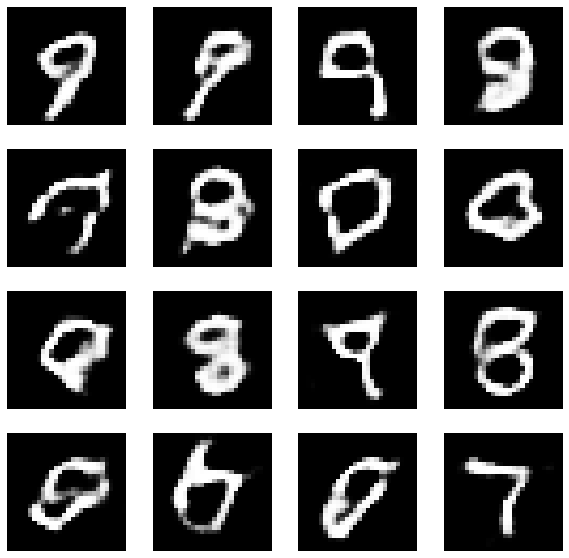

Epoca:  98


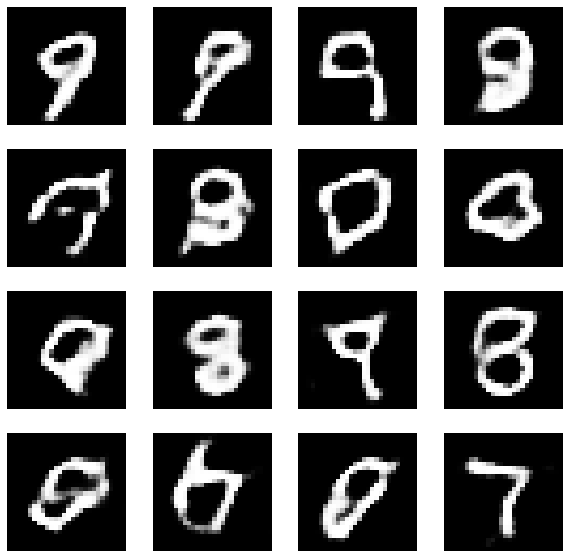

Epoca:  99


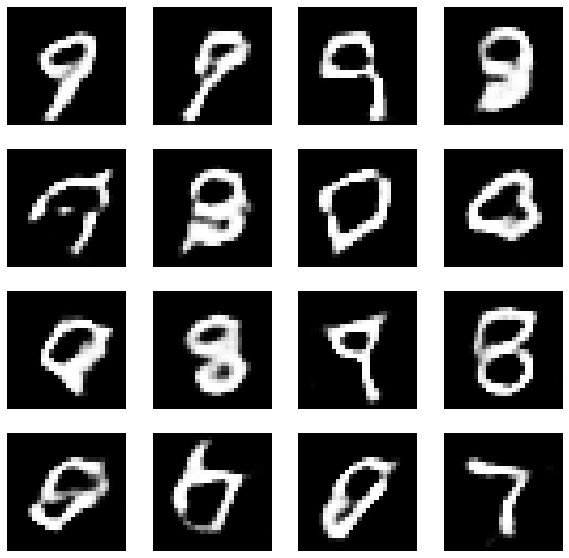

Epoca:  100


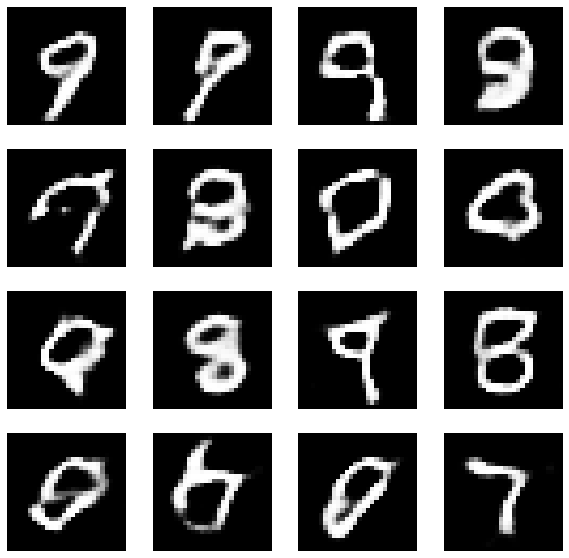

In [82]:
treina_gan(x_treinamento,epocas,imagens_teste)